In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


**Data Loading and understanding**

In [2]:
# load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/banking customer data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Features:**
RowNumber: The sequential number assigned to each row in the dataset.

CustomerId: A unique identifier for each customer.

Surname: The surname of the customer.

CreditScore: The credit score of the customer.

Geography: The geographical location of the customer (e.g., country or region).

Gender: The gender of the customer.

Age: The age of the customer.

Tenure: The number of years the customer has been with the bank.

Balance: The account balance of the customer.

NumOfProducts: The number of bank products the customer has.

HasCrCard: Indicates whether the customer has a credit card (binary: yes/no).

IsActiveMember: Indicates whether the customer is an active member (binary: yes/no).

EstimatedSalary: The estimated salary of the customer.

Exited: Indicates whether the customer has exited the bank (binary: yes/no).

In [3]:
df.shape

(10000, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# drop customer id and surname coloum as it is not required for modeling
df.drop(['CustomerId', 'Surname', 'RowNumber'], axis=1, inplace=True)
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [6]:
# printing the unique values of all columns
for col in df.columns:
  print(col , df[col].unique())
  print("-" * 50)

CreditScore [619 608 502 699 850 645 822 376 501 684 528 497 476 549 635 616 653 587
 726 732 636 510 669 846 577 756 571 574 411 591 533 553 520 722 475 490
 804 582 472 465 556 834 660 776 829 637 550 698 585 788 655 601 656 725
 511 614 742 687 555 603 751 581 735 661 675 738 813 657 604 519 664 678
 757 416 665 777 543 506 493 652 750 729 646 647 808 524 769 730 515 773
 814 710 413 623 670 622 785 605 479 685 538 562 721 628 668 828 674 625
 432 770 758 795 686 789 589 461 584 579 663 682 793 691 485 650 754 535
 716 539 706 586 631 717 800 683 704 615 667 484 480 578 512 606 597 778
 514 525 715 580 807 521 759 516 711 618 643 671 689 620 676 572 695 592
 567 694 547 594 673 610 767 763 712 703 662 659 523 772 545 634 739 771
 681 544 696 766 727 693 557 531 498 651 791 733 811 707 714 782 775 799
 602 744 588 747 583 627 731 629 438 642 806 474 559 429 680 749 734 644
 626 649 805 718 840 630 654 762 568 613 522 737 648 443 640 540 460 593
 801 611 802 745 483 690 492 709 705 56

In [7]:
# check there is any missing value
df.isnull().sum()

,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0
HasCrCard,0
IsActiveMember,0
EstimatedSalary,0


In [8]:
# check if there is any class/value count imbalance in the target variable
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


**Exploratory Data Analysis (EDA)**

In [9]:
# Understanding the numerical features (Column wise)
def plot_histogram(df, column_name):
  plt.figure(figsize=(5, 3))
  sns.histplot(df[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = df[column_name].mean()
  col_median = df[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()
  plt.show()

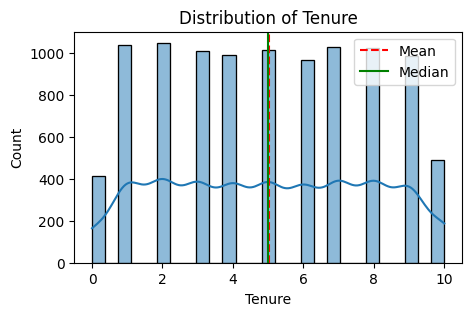

In [10]:
plot_histogram(df, 'Tenure')

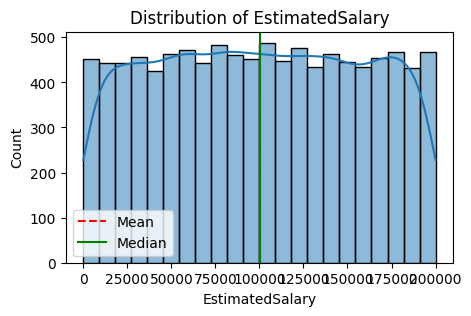

In [11]:
plot_histogram(df, 'EstimatedSalary')

In [12]:
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

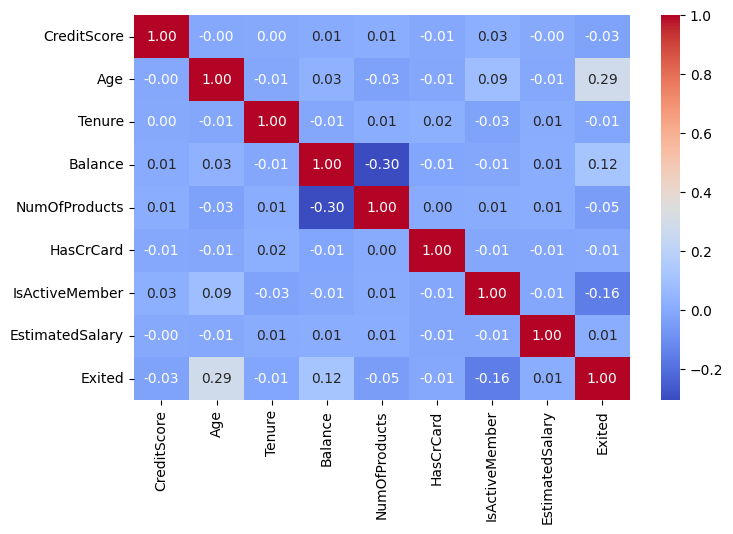

In [13]:
# Correlation Matrix between all numarical features (Heatmap)
plt.figure(figsize=(8, 5))
sns.heatmap(df[[ 'CreditScore', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

**Categorical features Analysis**

In [14]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


**Label encoding of categorical fetaures**

In [15]:
# # identifying columns with object data type
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['Geography', 'Gender'], dtype='object')


In [16]:
import pickle
# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder


# save the encoders to a pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)

In [17]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1


**Traianing and test data split**

In [18]:
# split feature and target column
X = df.drop(columns=["Exited"])
y = df['Exited']

In [19]:
# split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
print(y_train.value_counts())

Exited
0    6356
1    1644
Name: count, dtype: int64


***Synthetic Minority Oversampling Technique (SMOTE)***

In [21]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [22]:
print(y_train_smote.value_counts())

Exited
0    6356
1    6356
Name: count, dtype: int64


**Model Training**

Training with default hyperparameters

In [23]:
# dictionary of models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

In [24]:
# compare cross-validation accuracy for both models
# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("-"*70)

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.79
----------------------------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.85
----------------------------------------------------------------------


In [25]:
cv_scores

{'Decision Tree': array([0.72316162, 0.79276445, 0.81549961, 0.80802518, 0.8202203 ]),
 'Random Forest': array([0.75776642, 0.85922139, 0.88552321, 0.87844217, 0.89299764])}

Random Forest gives the highest accuracy compared to other models with default parameters

In [26]:
rfc = RandomForestClassifier(random_state=42)

In [27]:
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=42)

**Model Evaluation**

In [28]:
# rfc model evaluation with test data
potential_customer_pred = rfc.predict(X_test)
potential_customer_pred

array([0, 0, 0, ..., 1, 0, 0])

In [29]:
print("Accuracy Score:\n", accuracy_score(y_test, potential_customer_pred))
print("Confsuion Matrix:\n", confusion_matrix(y_test, potential_customer_pred))
print("Classification Report:\n", classification_report(y_test, potential_customer_pred))

Accuracy Score:
 0.825
Confsuion Matrix:
 [[1394  213]
 [ 137  256]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1607
           1       0.55      0.65      0.59       393

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.82      0.83      2000



In [30]:
import pickle
import pandas as pd

# Load the saved encoders
with open("encoders.pkl", "rb") as f:
    loaded_encoders = pickle.load(f)

# Example of new data with categorical features
new_customer_data = {
    'CreditScore': [650],
    'Geography': ['France'],
    'Gender': ['Female'],
    'Age': [35],
    'Tenure': [5],
    'Balance': [100000.00],
    'NumOfProducts': [2],
    'HasCrCard': [1],
    'IsActiveMember': [0],
    'EstimatedSalary': [50000.00]
}

new_customer_df = pd.DataFrame(new_customer_data)

# Apply the loaded encoders to the new data
for column, encoder in loaded_encoders.items():
    if column in new_customer_df.columns:
        new_customer_df[column] = encoder.transform(new_customer_df[column])

# Display the transformed data (ready for model prediction)
print("Transformed new customer data:")
print(new_customer_df)

Transformed new customer data:
   CreditScore  Geography  Gender  Age  Tenure   Balance  NumOfProducts  \
0          650          0       0   35       5  100000.0              2   

   HasCrCard  IsActiveMember  EstimatedSalary  
0          1               0          50000.0  


In [31]:
# predict churn with this new customer data
new_customer_pred = rfc.predict(new_customer_df)
new_customer_pred

array([1])

In [32]:
# save the model in pickle file
import pickle

# Save the trained Random Forest model to a pickle file
with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(rfc, f)

print("Random Forest model saved as random_forest_model.pkl")

Random Forest model saved as random_forest_model.pkl


**Determine which features have the most impact on the target variable ('Exited') by looking at the feature importances from trained Random Forest model**

Feature Importances:
Age                0.223779
EstimatedSalary    0.124686
Balance            0.118898
CreditScore        0.112446
IsActiveMember     0.109751
NumOfProducts      0.106590
Tenure             0.071048
Gender             0.063693
Geography          0.049571
HasCrCard          0.019538
dtype: float64


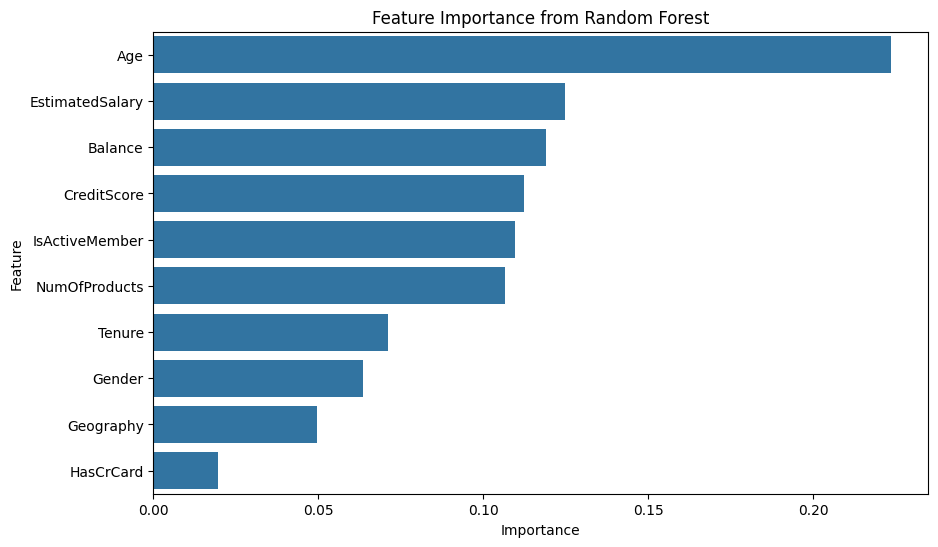

In [33]:
# Get feature importances from the trained Random Forest model
feature_importances = rfc.feature_importances_

# Create a pandas Series for better visualization
feature_importance_series = pd.Series(feature_importances, index=X_train_smote.columns)

# Sort features by importance
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Print the sorted feature importances
print("Feature Importances:")
print(sorted_feature_importances)

# Optionally, visualize the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances.values, y=sorted_feature_importances.index)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()